# 00 — Data Pipeline Test

Walk-through of every piece of the Phase 2 data pipeline:
loading, room inspection, distributions, feature extraction, splitting, and a hand-built sanity check.

In [1]:
# Cell 1: Load apartments
import json
from pathlib import Path

from furnisher_surrogate.data import load_apartments

apartments = load_apartments()
total_rooms = sum(len(a.rooms) for a in apartments)
print(f"Loaded {len(apartments)} apartments, {total_rooms} active rooms")

# Show manifest
manifest_path = Path("..") / "data" / "data_manifest.json"
manifest = json.loads(manifest_path.read_text())
print("\nManifest:")
for k, v in manifest.items():
    print(f"  {k}: {v}")

# First apartment
apt0 = apartments[0]
print(f"\nFirst apartment: seed={apt0.seed}, apt_type='{apt0.apt_type}', rooms={len(apt0.rooms)}")

Loaded 8322 apartments, 45880 active rooms

Manifest:
  source: C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_DesignExplorer\Furnisher\Apartment Quality Evaluation\apartments.jsonl
  sha256: f3ad376c42856c390cb0367f911ea5e0af7a964d2a7977ddfe9457f6f9b09e53
  rows: 8322
  active_rooms: 45880
  snapshot_date: 2026-02-25

First apartment: seed=696, apt_type='Studio (bedroom)', rooms=3


In [2]:
# Cell 2: Inspect Room objects
apt = apartments[0]
for r in apt.rooms:
    print(f"  {r.room_type:<15} polygon={r.polygon.shape}  door={r.door}  score={r.score}")

# Show raw polygon array for the first room
room0 = apt.rooms[0]
print(f"\nRaw polygon for '{room0.room_type}' (shape {room0.polygon.shape}):")
print(room0.polygon)

  Bedroom         polygon=(9, 2)  door=[0.6074 4.005 ]  score=71.0
  Bathroom        polygon=(5, 2)  door=[6.9483 2.2582]  score=100.0
  Kitchen         polygon=(5, 2)  door=[10.602   3.2147]  score=100.0

Raw polygon for 'Bedroom' (shape (9, 2)):
[[0.     0.    ]
 [3.8709 0.    ]
 [3.8709 3.9324]
 [2.9834 3.9324]
 [2.9834 4.6322]
 [0.6074 4.6322]
 [0.6074 2.6867]
 [0.     2.6867]
 [0.     0.    ]]


Apt type                  Apartments      Rooms
-----------------------------------------------
2-Bedroom                       2080      11659
1-Bedroom                       1662       7654
3-Bedroom                       1235       8143
4-Bedroom                        985       7496
Studio (living)                  893       2820
Studio (bedroom)                 830       2625
5-Bedroom                        637       5483


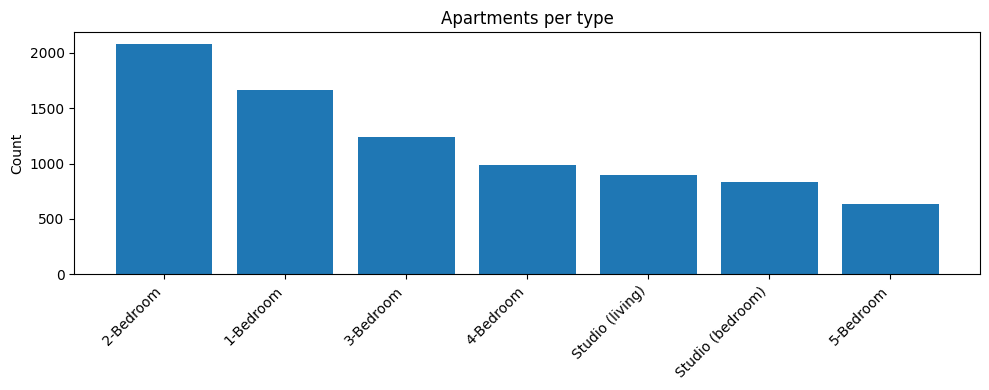

In [3]:
# Cell 3: Apartment type distribution
import matplotlib.pyplot as plt
from collections import Counter

apt_type_counts = Counter(a.apt_type for a in apartments)
room_per_apt_type = Counter()
for a in apartments:
    room_per_apt_type[a.apt_type] += len(a.rooms)

# Sort by count descending
sorted_types = sorted(apt_type_counts.keys(), key=lambda t: apt_type_counts[t], reverse=True)

print(f"{'Apt type':<25} {'Apartments':>10} {'Rooms':>10}")
print("-" * 47)
for t in sorted_types:
    print(f"{t:<25} {apt_type_counts[t]:>10} {room_per_apt_type[t]:>10}")

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(sorted_types)), [apt_type_counts[t] for t in sorted_types], label="Apartments")
ax.set_xticks(range(len(sorted_types)))
ax.set_xticklabels(sorted_types, rotation=45, ha="right")
ax.set_ylabel("Count")
ax.set_title("Apartments per type")
plt.tight_layout()
plt.show()

Room type          Count        %
---------------------------------
Bedroom             7429   16.2%
Living room         7492   16.3%
Bathroom            8322   18.1%
WC                  4262    9.3%
Kitchen             8322   18.1%
Children 1          4937   10.8%
Children 2          2857    6.2%
Children 3          1622    3.5%
Children 4           637    1.4%


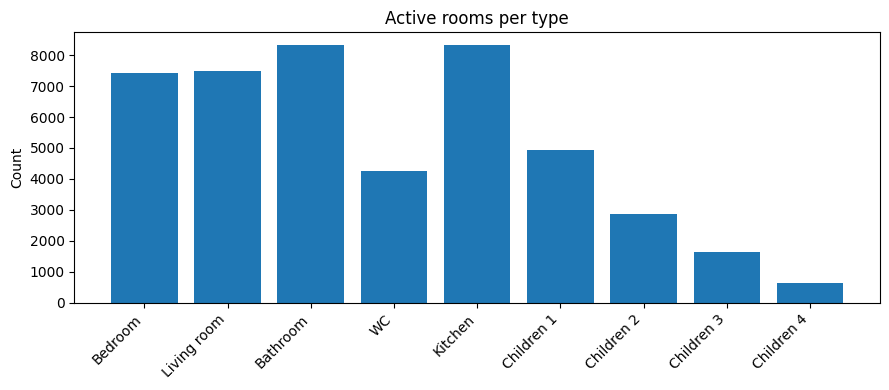

In [4]:
# Cell 4: Room type distribution
from furnisher_surrogate.data import ROOM_TYPES

all_rooms = [r for a in apartments for r in a.rooms]
room_type_counts = Counter(r.room_type for r in all_rooms)

print(f"{'Room type':<15} {'Count':>8} {'%':>8}")
print("-" * 33)
for rt in ROOM_TYPES:
    c = room_type_counts.get(rt, 0)
    print(f"{rt:<15} {c:>8} {c / len(all_rooms):>7.1%}")

fig, ax = plt.subplots(figsize=(9, 4))
counts = [room_type_counts.get(rt, 0) for rt in ROOM_TYPES]
ax.bar(ROOM_TYPES, counts)
ax.set_ylabel("Count")
ax.set_title("Active rooms per type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

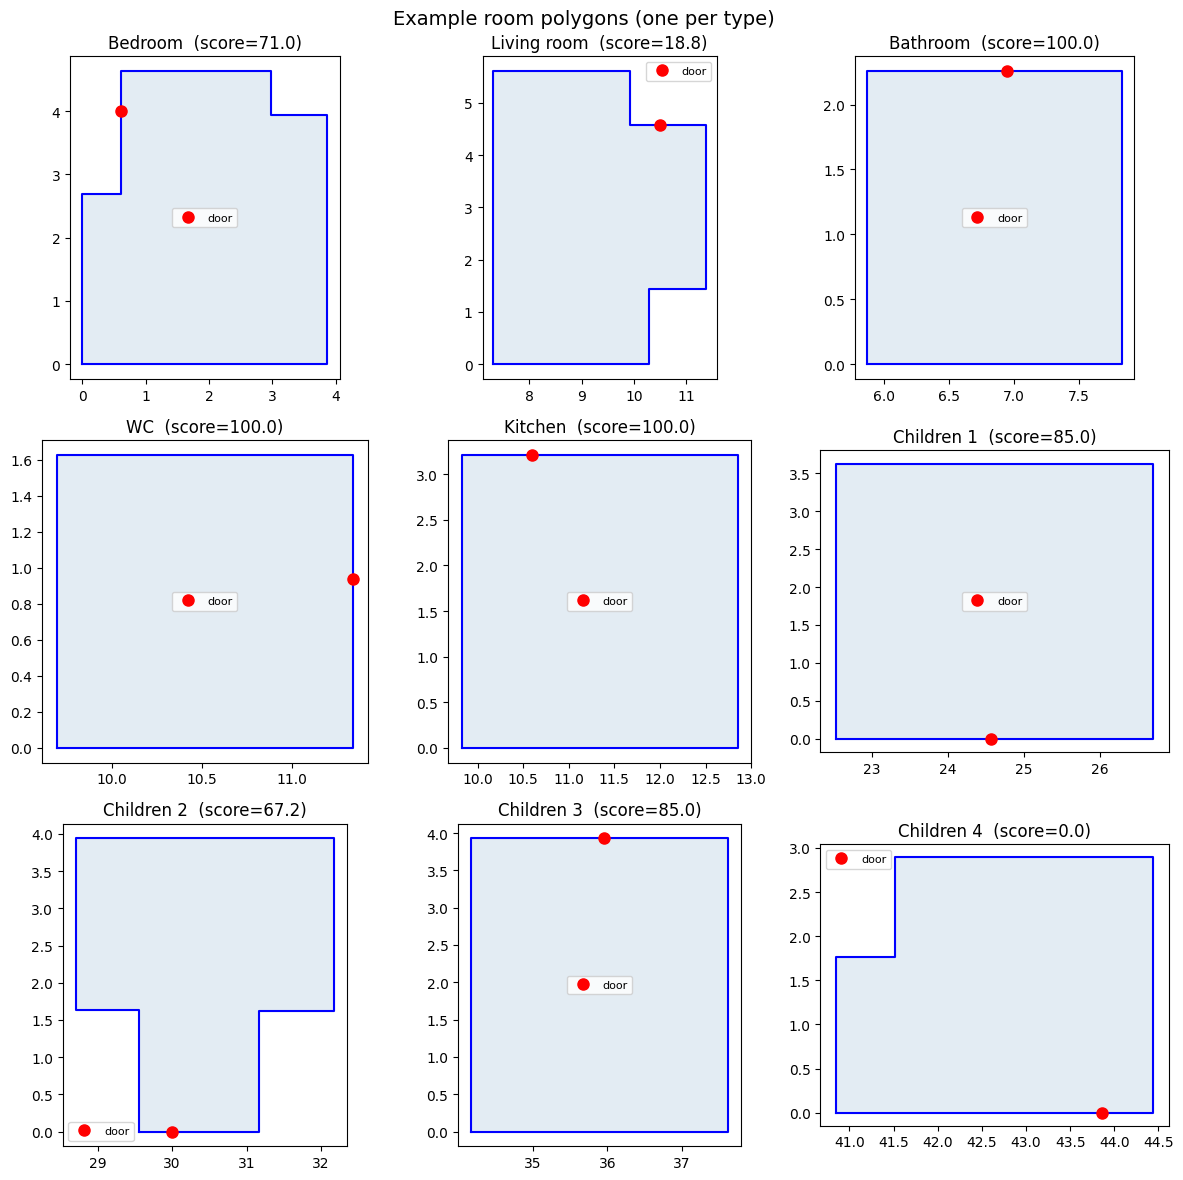

In [5]:
# Cell 5: Visualize room polygons (one per room type)
import numpy as np

# Pick one example room per type
example_rooms = {}
for r in all_rooms:
    if r.room_type not in example_rooms:
        example_rooms[r.room_type] = r
    if len(example_rooms) == len(ROOM_TYPES):
        break

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, rt in zip(axes.flat, ROOM_TYPES):
    room = example_rooms[rt]
    poly = room.polygon
    ax.fill(poly[:, 0], poly[:, 1], alpha=0.15, color="steelblue")
    ax.plot(poly[:, 0], poly[:, 1], "b-", linewidth=1.5)
    ax.plot(*room.door, "ro", markersize=8, label="door")
    ax.set_title(f"{rt}  (score={room.score})")
    ax.set_aspect("equal")
    ax.legend(fontsize=8)

plt.suptitle("Example room polygons (one per type)", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Feature extraction — single room
from furnisher_surrogate.features import (
    area,
    aspect_ratio,
    n_vertices,
    door_rel_position,
    extract_features,
    FEATURE_NAMES,
)

room = all_rooms[0]
print(f"Room: {room.room_type}, score={room.score}")
print(f"  area            = {area(room):.3f} m²")
print(f"  aspect_ratio    = {aspect_ratio(room):.3f}")
print(f"  n_vertices      = {n_vertices(room)}")
dx, dy = door_rel_position(room)
print(f"  door_rel_x      = {dx:.3f}")
print(f"  door_rel_y      = {dy:.3f}")

feat = extract_features(room)
print(f"\nFull feature vector ({feat.shape[0]} dims):")
for name, val in zip(FEATURE_NAMES, feat):
    print(f"  {name:<25} {val:.4f}")

Room: Bedroom, score=71.0
  area            = 16.128 m²
  aspect_ratio    = 1.197
  n_vertices      = 8
  door_rel_x      = 0.157
  door_rel_y      = 0.865

Full feature vector (14 dims):
  area                      16.1280
  aspect_ratio              1.1967
  n_vertices                8.0000
  door_rel_x                0.1569
  door_rel_y                0.8646
  room_type_Bedroom         1.0000
  room_type_Living room     0.0000
  room_type_Bathroom        0.0000
  room_type_WC              0.0000
  room_type_Kitchen         0.0000
  room_type_Children 1      0.0000
  room_type_Children 2      0.0000
  room_type_Children 3      0.0000
  room_type_Children 4      0.0000


In [7]:
# Cell 7: Feature extraction — batch
import pandas as pd
from furnisher_surrogate.features import extract_feature_matrix, extract_scores

X = extract_feature_matrix(all_rooms)
y = extract_scores(all_rooms)
print(f"Feature matrix shape: {X.shape}")
print(f"Score vector shape:   {y.shape}")
print(f"Scores — min: {y.min():.1f}, max: {y.max():.1f}, mean: {y.mean():.1f}")

# Show first 10 rows as a DataFrame
df = pd.DataFrame(X[:10], columns=FEATURE_NAMES)
df.insert(0, "score", y[:10])
df.insert(0, "room_type", [all_rooms[i].room_type for i in range(10)])
df

Feature matrix shape: (45880, 14)
Score vector shape:   (45880,)
Scores — min: 0.0, max: 100.0, mean: 62.2


,room_type,score,area,aspect_ratio,n_vertices,door_rel_x,door_rel_y,room_type_Bedroom,room_type_Living room,room_type_Bathroom,room_type_WC,room_type_Kitchen,room_type_Children 1,room_type_Children 2,room_type_Children 3,room_type_Children 4
0,Bedroom,71.000000,16.128014,1.196673,8.0,0.156914,0.864600,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bathroom,100.000000,4.419072,1.153968,4.0,0.550565,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Kitchen,100.000000,9.716431,1.063590,4.0,0.256146,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Bedroom,100.000000,21.431391,1.122084,6.0,0.584748,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bathroom,0.000000,1.669402,1.238501,4.0,1.000000,0.302664,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,WC,100.000000,2.678552,1.010380,4.0,1.000000,0.577447,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,Kitchen,75.000000,10.318839,1.096646,6.0,0.715226,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,Bedroom,96.500000,20.254959,1.276163,6.0,0.267982,0.790648,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Living room,18.799999,19.741463,1.376909,8.0,0.784946,0.815216,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Bathroom,0.000000,2.621738,1.395418,4.0,0.448384,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Cell 8: Train / val / test split
from furnisher_surrogate.data import assign_splits, get_rooms_by_split

split_map = assign_splits(apartments)
rooms_by_split = get_rooms_by_split(apartments, split_map)

# Count apartments per split
apt_split_counts = Counter(split_map.values())

print(f"{'Split':<8} {'Apartments':>12} {'Rooms':>10} {'Apt %':>8} {'Room %':>8}")
print("-" * 50)
for s in ("train", "val", "test"):
    na = apt_split_counts[s]
    nr = len(rooms_by_split[s])
    print(f"{s:<8} {na:>12} {nr:>10} {na / len(apartments):>7.1%} {nr / total_rooms:>7.1%}")

# Verify no apartment appears in multiple splits
split_seeds = {}
for seed, split in split_map.items():
    if seed in split_seeds:
        raise AssertionError(f"Seed {seed} in both {split_seeds[seed]} and {split}")
    split_seeds[seed] = split
assert len(split_map) == len(apartments), "Every apartment has a split"
print("\nNo apartment seed appears in multiple splits.")

Split      Apartments      Rooms    Apt %   Room %
--------------------------------------------------
train            6657      36702   80.0%   80.0%
val               832       4584   10.0%   10.0%
test              833       4594   10.0%   10.0%

No apartment seed appears in multiple splits.


In [9]:
# Cell 9: Split stratification check
rows = []
for s in ("train", "val", "test"):
    apts_in_split = [a for a in apartments if split_map[a.seed] == s]
    type_counts = Counter(a.apt_type for a in apts_in_split)
    total = len(apts_in_split)
    for t in sorted_types:
        rows.append({"split": s, "apt_type": t, "count": type_counts.get(t, 0), "pct": type_counts.get(t, 0) / total})

df_strat = pd.DataFrame(rows)
pivot = df_strat.pivot(index="apt_type", columns="split", values="pct")
pivot = pivot[["train", "val", "test"]].loc[sorted_types]

print("Apartment-type proportions per split (should be similar across columns):")
print(pivot.map(lambda x: f"{x:.1%}").to_string())

Apartment-type proportions per split (should be similar across columns):
split             train    val   test
apt_type                             
2-Bedroom         25.0%  25.0%  25.0%
1-Bedroom         20.0%  20.0%  20.0%
3-Bedroom         14.8%  14.8%  14.9%
4-Bedroom         11.8%  11.8%  11.9%
Studio (living)   10.7%  10.8%  10.7%
Studio (bedroom)  10.0%  10.0%  10.0%
5-Bedroom          7.7%   7.7%   7.6%


In [10]:
# Cell 10: Hand-built room sanity check
from furnisher_surrogate.data import Room, ROOM_TYPE_TO_IDX

# 4m x 3m rectangle, door at midpoint of bottom edge
polygon = np.array([
    [0.0, 0.0],
    [4.0, 0.0],
    [4.0, 3.0],
    [0.0, 3.0],
    [0.0, 0.0],  # closing vertex
], dtype=np.float64)

door = np.array([2.0, 0.0], dtype=np.float64)

test_room = Room(
    polygon=polygon,
    door=door,
    room_type="Bedroom",
    room_type_idx=ROOM_TYPE_TO_IDX["Bedroom"],
    score=85.0,
)

# Check individual features
a = area(test_room)
ar = aspect_ratio(test_room)
nv = n_vertices(test_room)

checks = [
    ("area == 12.0", abs(a - 12.0) < 1e-9),
    ("aspect_ratio == 4/3", abs(ar - 4.0 / 3.0) < 1e-9),
    ("n_vertices == 4", nv == 4),
]

all_pass = True
for label, passed in checks:
    status = "PASS" if passed else "FAIL"
    if not passed:
        all_pass = False
    print(f"  [{status}] {label}")

if all_pass:
    print("\nAll sanity checks passed.")
else:
    raise AssertionError("One or more sanity checks failed!")

  [PASS] area == 12.0
  [PASS] aspect_ratio == 4/3
  [PASS] n_vertices == 4

All sanity checks passed.
